In [1]:
import os
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns
import snapfish2
snapfish2.MulFish.default_cols.extend(["Replicate", "FOV"])

In [2]:
%reload_ext autoreload
%autoreload 2

- optimal weights
- chromtic aberrations
- global background
- ground truth
- comments & documentations
- differential interaction
- live cell
- against a fixed distance
- new aligner

In [3]:
np.random.seed(100)

In [4]:
data_dire = "../../data/takei_nature_2021"
rep_paths = ["4DNFIHF3JCBY.csv", "4DNFIQXONUUH.csv"]
# data_dire = "../../data/jie_aligned_takei_nature_2021"
# rep_paths = ["4DNFIVBL8AWT.csv", "4DNFI7G3BWDF.csv"]
mfrs = []
for i, rep_path in enumerate(rep_paths):
    path = os.path.join(data_dire, rep_path)
    mfrs.append(snapfish2.MulFish(path))
    # Extract FOV ID
    mfrs[-1].data["FOV"] = mfrs[-1].data["Cell_ID"].str.extract(r"(\d+)\_\d+")
    # Add replicate ID to Trace_ID and as a separate column
    mfrs[-1].data["Trace_ID"] = f"{i}_" + mfrs[-1].data["Trace_ID"]
    mfrs[-1].data["Replicate"] = f"rep{i}"
    # Convert voxel coordinates to nm
    mfrs[-1].data["X"] *= 103
    mfrs[-1].data["Y"] *= 103
    mfrs[-1].data["Z"] *= 250
concat_df = pd.concat([m.data for m in mfrs])
mfr = snapfish2.MulFish(concat_df)

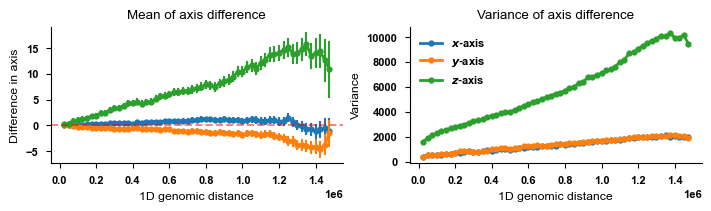

In [5]:
a, arrs = snapfish2.utils.to_very_wide(mfr["chr1"])
d1d = a.index.values
fig, daxis_df = snapfish2.plot.daxis_dist(d1d, arrs)

In [6]:
noised = mfr.data.copy()
# noised["X"] += stats.norm.rvs(size=(len(mfr.data["X"])), scale=50)
# noised["Y"] += stats.norm.rvs(size=(len(mfr.data["Y"])), scale=50)
noised["Z"] += stats.norm.rvs(size=(len(mfr.data["Z"])), scale=50)
slc = snapfish2.LoopCaller(noised)

In [11]:
snapfish2.analysis.FDR_CUT_F = snapfish2.analysis.FDR_CUT_T = 1e-1

/Users/redfishhh/Documents/research/MultiplexedFISH/library/snapfish2/loop/caller.py:312: RuntimeWarning: invalid value encountered in divide
  freq_mat = np.sum(dmaps<freq_cut, axis=0)/np.sum(~np.isnan(dmaps), axis=0)


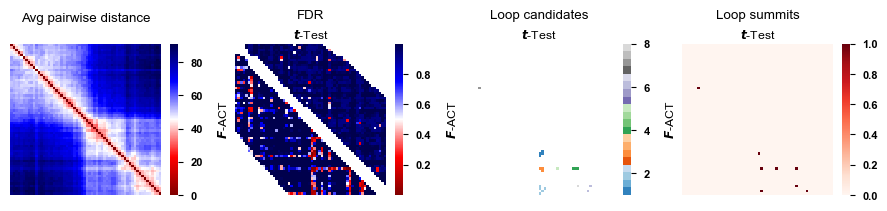

In [12]:
chr_id = "chr3"
chr_df, arr = snapfish2.utils.to_very_wide(mfr[chr_id])
dmaps = np.sqrt(np.sum(np.square(arr), axis=1))
x, y = r"$t$-Test", r"$F$-ACT"
t1 = slc.loops_from_single_reg(chr_id, snapfish2.TwoSampleT)
t2 = slc.loops_from_single_reg(chr_id, snapfish2.AxisWiseF)
fig, axes = plt.subplots(1, 4, figsize=(9, 2))
snapfish2.plot.pairwise_heatmap(dmaps, title=f"Avg pairwise distance", x=" ", ax=axes[0])
snapfish2.plot.pairwise_heatmap(X1=t1["fdr"], X2=t2["fdr"], x=x, y=y, title="FDR", ax=axes[1])
snapfish2.plot.pairwise_heatmap(X1=t1["labeled"], X2=t2["labeled"], x=x, y=y, title="Loop candidates", cmap="tab20c", ax=axes[2])
snapfish2.plot.pairwise_heatmap(X1=t1["summit"], X2=t2["summit"], x=x, y=y, title="Loop summits", cmap="Reds", ax=axes[3])

In [13]:
mfr[chr_id]

,Trace_ID,Chrom_Start,Spot_ID,X,Y,Z,Chrom,Chrom_End,Cell_ID,Extra_Cell_ROI_ID,locus,FOV,Replicate
50520,0_0_1_3_1,7675000,705305.0,16881.391,2260.026,444.00,chr3,7700000,0_1,0.0,0,0,rep0
50521,0_0_1_3_1,7700000,705308.0,16865.220,2271.459,751.50,chr3,7725000,0_1,0.0,1,0,rep0
50522,0_0_1_3_1,7750000,705309.0,16887.571,2267.648,611.25,chr3,7775000,0_1,0.0,2,0,rep0
50523,0_0_1_3_1,7775000,705310.0,16849.564,2267.339,632.75,chr3,7800000,0_1,0.0,3,0,rep0
50524,0_0_1_3_1,7800000,705312.0,16848.946,2272.592,640.25,chr3,7825000,0_1,0.0,4,0,rep0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
92035,1_5_38_3_1,9200000,1578101.0,1496.384,4333.004,650.00,chr3,9225000,5_38,5.0,55,5,rep1
92036,1_5_38_3_1,9225000,1578102.0,1494.015,4329.914,701.50,chr3,9250000,5_38,5.0,56,5,rep1
92037,1_5_38_3_1,9250000,NaN,NaN,NaN,NaN,chr3,9275000,5_38,NaN,57,5,rep1
92038,1_5_38_3_1,9275000,NaN,NaN,NaN,NaN,chr3,9300000,5_38,NaN,58,5,rep1


In [29]:
i1, j1, i2, j2 = 40, 50, 41, 53
x1, x2 = arr[:,0,i1,j1].copy(), arr[:,0,i2,j2].copy()
# x1[np.abs(x1) > 100] = 0
# x2[np.abs(x2) > 100] = 0
F = np.nanvar(x1, ddof=1)/np.nanvar(x2, ddof=1)
stats.f.cdf(F, np.sum(~np.isnan(x1)), np.sum(~np.isnan(x2)))

2.2258034216912894e-17

<Axes: ylabel='Count'>

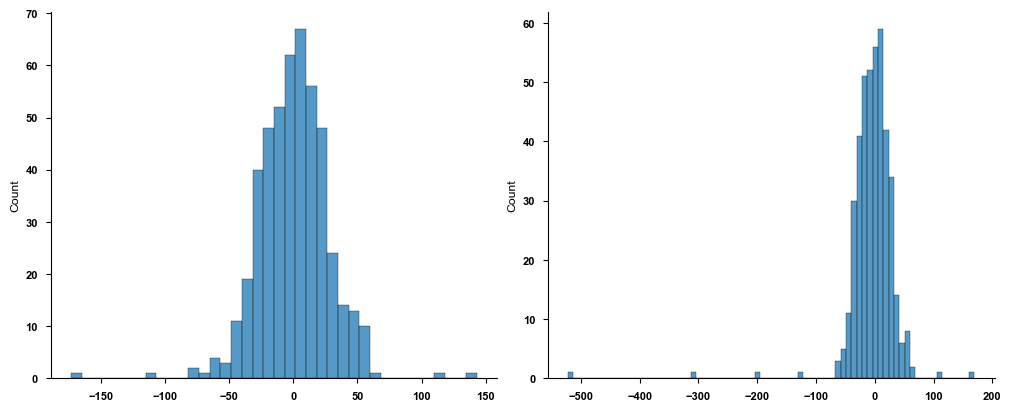

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.histplot(x1, ax=axes[0])
sns.histplot(x2, ax=axes[1])

very same


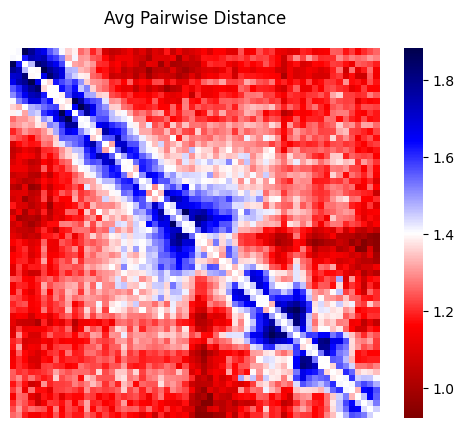

In [85]:
narrs = snapfish2.analysis.caller.AxisWiseChi2.preprocess(d1d=d1d, arrs=arr)
dmaps = np.sqrt(np.sum(np.square(narrs), axis=1))
snapfish2.plot.pairwise_heatmap(dmaps, title=f"Avg Pairwise Distance", x=" ")